# 氢链模型
## 主程序 0 ：基网络的搭建与训练，采用硬件高效拟设 (HEA)

In [3]:
import os
import numpy as np
import mindspore as ms
from mindquantum import *
import matplotlib.pyplot as plt
import mindspore.context as context
from openfermionpyscf import run_pyscf
from openfermion.chem import MolecularData
ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")
np.random.seed(1)
ms.set_seed(1)

# 定义分子结构
blen = 0.74
geom_2 = [('H', [0, 0, 0]), ('H', [0, 0, blen])]
basis = "sto3g"
spin_2 = 0

molecule_2 = MolecularData(geom_2, basis,  multiplicity=2 * spin_2+ 1)
molecule_2 = run_pyscf(molecule_2, run_scf=1, run_ccsd=1, run_fci=0)
molecule_2.save()
molecule_2 = molecule_2.filename
_, _, _, ham_2, base_qubit_num, _ = generate_uccsd(molecule_2, threshold=-1) # 生成哈密顿量

def net_work(qubit_num=4, layer_num=4): # 生成网络

    circ = Circuit()
    for layer in range(layer_num):
        for qubit in range(qubit_num):
            circ += RZ(para_names[int(3 *  qubit_num * layer + 3  * qubit + 0)]).on(qubit)
            circ += RX(para_names[int(3 *  qubit_num * layer + 3 * qubit + 1)]).on(qubit)
            circ += RZ(para_names[int(3 *  qubit_num * layer + 3 * qubit + 2)]).on(qubit)

        for i in range(qubit_num - 1):
            circ += Z.on(i+1, i)
        circ += Z.on(qubit_num - 1, 0)
    return circ

base_layer_num = base_qubit_num
para_names = np.array(range(3 * base_qubit_num * base_layer_num)).astype(str) # 生成目标网络中所有参数的名字
base_net = net_work(qubit_num=base_qubit_num, layer_num=base_layer_num)

sample_num = 100 # 最后要对多次训练结果进行分析，设置采样次数

sim = Simulator('mqvector', base_net.n_qubits)
grad_ops = sim.get_expectation_with_grad(Hamiltonian(ham_2), base_net)

paras_list = [] # 参数保存
for num in range(sample_num): # 采样多次
    net = MQAnsatzOnlyLayer(grad_ops)   # 搭建网络
    opti = ms.nn.Adam(net.trainable_params(), learning_rate=0.05)    # 优化器
    train_net = ms.nn.TrainOneStepCell(net, opti)  # 调用一次，就训练一次
    # print('\n初始期望值为：',train_net()[0])

    for i in range(200): # 训练 200 个回合，已足够收敛
        train_net()[0]

    # print('最终期望值为!', train_net()[0])
    paras_list.append(net.weight.asnumpy()) # 保存收敛后的基网络参数

base_net_paras = np.array(paras_list)
print('\n收敛参数为：\n', base_net_paras.shape)

np.save('./src/Hydrogen_base_net_paras.npy', base_net_paras)  # 导出数据
print('\n导出完成啦!')

# a = np.load('./src/Hydrogen_base_net_paras.npy', allow_pickle=True) # 重新导入，以检验
# print('\n检验参数维度为：\n', a.shape)

ccsd:-1.13728399861044.
fci:None.

收敛参数为：
 (100, 48)

导出完成啦!


## 主程序 1：采用网络迁移，不同参数迁移策略，不同尺寸下目标网络首个有效参数梯度方差的变化情况（HEA 拟设）。

In [ ]:
import os
import numpy as np
import mindspore as ms
from mindquantum import *
import matplotlib.pyplot as plt
import mindspore.context as context
from openfermionpyscf import run_pyscf
from openfermion.chem import MolecularData
ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")
np.random.seed(1)
ms.set_seed(1)

blen = 0.74 # 键长
geom_2 = [('H', [0, 0, 0]), ('H', [0, 0, blen])]
geom_3 = [('H', [0, 0, 0]), ('H', [blen, blen, blen]), ('H', [blen, -blen, -blen])]
geom_4 = [('H', [0, 0, 0]), ('H', [blen, blen, blen]), ('H', [blen, -blen, -blen]), ('H', [-blen, blen, -blen])]
geom_5 = [('H', [0, 0, 0]), ('H', [blen, blen, blen]), ('H', [blen, -blen, -blen]), ('H', [-blen, blen, -blen]), ('H', [-blen, -blen, -blen])]
basis = "sto3g"

spin_2 = 0
spin_3 = 1
spin_4 = 0
spin_5 = 1

molecule_2 = MolecularData(geom_2, basis,  multiplicity=2 * spin_2+ 1)
molecule_2 = run_pyscf(molecule_2, run_scf=1, run_ccsd=1, run_fci=0)

molecule_3 = MolecularData(geom_3, basis,  multiplicity=2 * spin_3)
molecule_3 = run_pyscf(molecule_3, run_scf=1, run_ccsd=1, run_fci=0)

molecule_4 = MolecularData(geom_4, basis,  multiplicity=2 * spin_4 + 1)
molecule_4 = run_pyscf(molecule_4, run_scf=1, run_ccsd=1, run_fci=0)

molecule_5 = MolecularData(geom_5, basis,  multiplicity=2 * spin_5)
molecule_5 = run_pyscf(molecule_5, run_scf=1, run_ccsd=1, run_fci=0)

molecule_2.save()
molecule_3.save()
molecule_4.save()
molecule_5.save()

molecule_2 = molecule_2.filename
molecule_3 = molecule_3.filename
molecule_4 = molecule_4.filename
molecule_5 = molecule_5.filename

def net_work(qubit_num=4, layer_num=4): # 生成网络

    circ = Circuit()
    for layer in range(layer_num):
        for qubit in range(qubit_num):
            circ += RZ(para_names[int(3 *  qubit_num * layer + 3  * qubit + 0)]).on(qubit)
            circ += RX(para_names[int(3 *  qubit_num * layer + 3 * qubit + 1)]).on(qubit)
            circ += RZ(para_names[int(3 *  qubit_num * layer + 3 * qubit + 2)]).on(qubit)

        for i in range(qubit_num - 1):
            circ += Z.on(i+1, i)
        circ += Z.on(qubit_num - 1, 0)
    return circ

def get_rr_var(circuit,  hamiltonian, sample_num = 10):   # r 表示随机参数层  t 表示最佳参数层。 rr 表示整个目标网络都是由随机参数层构成
    simulator = Simulator('mqvector', qubit_num)
    grad_ops = simulator.get_expectation_with_grad(hamiltonian, circuit)
    avg_var = 0
    for i in range(sample_num):
        paras = np.random.rand(len(circuit.params_name))*2*np.pi
        avg_var += grad_ops(paras)[1][0,0,1].real**2 / sample_num
    return avg_var

def get_tt_var(circuit,  hamiltonian, sample_num = 10):   # r 表示随机参数层  t 表示最佳参数层。 tt 表示整个目标网络都是由最佳参数层构成 只有最上面 4 个比特的参数迁移
    simulator = Simulator('mqvector', qubit_num)
    grad_ops = simulator.get_expectation_with_grad(hamiltonian, circuit)
    avg_var = 0
    for i in range(sample_num):
        paras = np.array([])
        for _ in range(int(layer_num/base_layer_num)):
            paras = np.append(paras, base_net_paras[i][0:12])
            paras = np.append(paras, np.random.rand(int(3 * (qubit_num - base_qubit_num))) * 2 * np.pi)
            paras = np.append(paras, base_net_paras[i][12:24])
            paras = np.append(paras, np.random.rand(int(3 * (qubit_num - base_qubit_num))) * 2 * np.pi)
            paras = np.append(paras, base_net_paras[i][24:36])
            paras = np.append(paras, np.random.rand(int(3 * (qubit_num - base_qubit_num))) * 2 * np.pi)
            paras = np.append(paras, base_net_paras[i][36:48])
            paras = np.append(paras, np.random.rand(int(3 * (qubit_num - base_qubit_num))) * 2 * np.pi)
        avg_var += grad_ops(paras)[1][0,0,1].real**2 / sample_num
    return avg_var

sample_num = 100 # 最后要对多次训练结果进行分析，设置采样次数
base_net_paras = np.load('./src/Hydrogen_base_net_paras.npy', allow_pickle=True)

# 先计算基网络的情况
_, _, _, ham_2, base_qubit_num, _ = generate_uccsd(molecule_2, th=-1)
base_layer_num = base_qubit_num
para_names = np.array(range(3 * base_qubit_num * base_layer_num)).astype(str) # 生成目标网络中所有参数的名字
base_net = net_work(qubit_num=base_qubit_num, layer_num=base_layer_num)

sim = Simulator('mqvector', base_net.n_qubits)
grad_ops = sim.get_expectation_with_grad(Hamiltonian(ham_2), base_net)
base_avg_var = get_rr_var(base_net, Hamiltonian(ham_2), sample_num=sample_num)

avg_rr_var_list = [base_avg_var]
avg_tt_var_list = [base_avg_var]

for molecule in [molecule_3, molecule_4, molecule_5]: # 比特范围为 4 到 12
    _, _, _, ham, qubit_num, _ = generate_uccsd(molecule, th=-1)
    hamiltonian  = Hamiltonian(ham)
    layer_num = int((1 + (qubit_num - base_qubit_num)/2) * base_layer_num)
    para_names = np.array(range(3 * qubit_num * layer_num)).astype(str) # 生成目标网络中所有参数的名字
    ansatz = net_work(qubit_num=qubit_num, layer_num=layer_num)

    avg_var = get_rr_var(ansatz, hamiltonian, sample_num=sample_num)
    avg_rr_var_list.append(avg_var)

    avg_var = get_tt_var(ansatz, hamiltonian, sample_num=sample_num)
    avg_tt_var_list.append(avg_var)

plt.figure()
plt.plot(avg_rr_var_list, label = 'RR', linestyle='--', marker='o', color='b') # 网络最上面 5 个比特采用随机参数初始化层
plt.plot(avg_tt_var_list, label = 'TT', linestyle='--', marker='o', color='r') # 网络最上面 5 个比特采用最优参数初始化层
plt.title('Hydrogen model, HEA and structure transfer', fontsize=12)
plt.legend()
plt.xlabel('number of qubits', fontsize=10)
plt.xticks(ticks=[0, 1, 2, 3], labels=[4, 6, 8, 10])
plt.ylabel(r'variance of $\partial_0C$ ', fontsize=10)
plt.savefig('./src/Fig3b.png')
plt.show()

## 主程序 2：采用结构迁移，不同参数迁移策略，不同尺寸下目标网络所有参数的正则化梯度范数变化情况。

The parameters you are using now:
 geometry:
 [('H', [0, 0, 0]), ('H', [0, 0, 0.74])] 
basis:
 sto3g 
multiplicity:
 1 
charge:
 0 
description:
 None 
filename:
 /usr/local/lib/python3.7/dist-packages/hiqfermion/drivers/data/H2_sto3g_singlet 
data_directory:
 None
The parameters you are using now:
 geometry:
 [('H', [0, 0, 0]), ('H', [0.74, 0.74, 0.74]), ('H', [0.74, -0.74, -0.74])] 
basis:
 sto3g 
multiplicity:
 2 
charge:
 0 
description:
 None 
filename:
 /usr/local/lib/python3.7/dist-packages/hiqfermion/drivers/data/H3_sto3g_doublet 
data_directory:
 None
The parameters you are using now:
 geometry:
 [('H', [0, 0, 0]), ('H', [0.74, 0.74, 0.74]), ('H', [0.74, -0.74, -0.74]), ('H', [-0.74, 0.74, -0.74])] 
basis:
 sto3g 
multiplicity:
 1 
charge:
 0 
description:
 None 
filename:
 /usr/local/lib/python3.7/dist-packages/hiqfermion/drivers/data/H4_sto3g_singlet 
data_directory:
 None
The parameters you are using now:
 geometry:
 [('H', [0, 0, 0]), ('H', [0.74, 0.74, 0.74]), ('H', [0.74

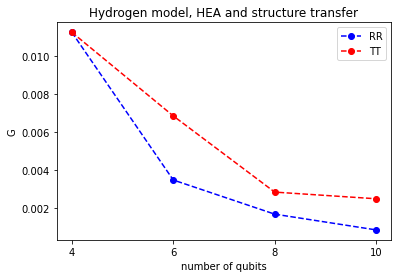

In [13]:
import os
import numpy as np
import mindspore as ms
from mindquantum import *
import matplotlib.pyplot as plt
import mindspore.context as context
from openfermionpyscf import run_pyscf
from openfermion.chem import MolecularData
ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")
np.random.seed(1)
ms.set_seed(1)

blen = 0.74 # 键长
geom_2 = [('H', [0, 0, 0]), ('H', [0, 0, blen])]
geom_3 = [('H', [0, 0, 0]), ('H', [blen, blen, blen]), ('H', [blen, -blen, -blen])]
geom_4 = [('H', [0, 0, 0]), ('H', [blen, blen, blen]), ('H', [blen, -blen, -blen]), ('H', [-blen, blen, -blen])]
geom_5 = [('H', [0, 0, 0]), ('H', [blen, blen, blen]), ('H', [blen, -blen, -blen]), ('H', [-blen, blen, -blen]), ('H', [-blen, -blen, -blen])]
basis = "sto3g"

spin_2 = 0
spin_3 = 1
spin_4 = 0
spin_5 = 1

molecule_2 = MolecularData(geom_2, basis,  multiplicity=2 * spin_2+ 1)
molecule_2 = run_pyscf(molecule_2, run_scf=1, run_ccsd=1, run_fci=0)

molecule_3 = MolecularData(geom_3, basis,  multiplicity=2 * spin_3)
molecule_3 = run_pyscf(molecule_3, run_scf=1, run_ccsd=1, run_fci=0)

molecule_4 = MolecularData(geom_4, basis,  multiplicity=2 * spin_4 + 1)
molecule_4 = run_pyscf(molecule_4, run_scf=1, run_ccsd=1, run_fci=0)

molecule_5 = MolecularData(geom_5, basis,  multiplicity=2 * spin_5)
molecule_5 = run_pyscf(molecule_5, run_scf=1, run_ccsd=1, run_fci=0)

molecule_2.save()
molecule_3.save()
molecule_4.save()
molecule_5.save()

molecule_2 = molecule_2.filename
molecule_3 = molecule_3.filename
molecule_4 = molecule_4.filename
molecule_5 = molecule_5.filename

def net_work(qubit_num=4, layer_num=4): # 生成网络

    circ = Circuit()
    for layer in range(layer_num):
        for qubit in range(qubit_num):
            circ += RZ(para_names[int(3 *  qubit_num * layer + 3  * qubit + 0)]).on(qubit)
            circ += RX(para_names[int(3 *  qubit_num * layer + 3 * qubit + 1)]).on(qubit)
            circ += RZ(para_names[int(3 *  qubit_num * layer + 3 * qubit + 2)]).on(qubit)

        for i in range(qubit_num - 1):
            circ += Z.on(i+1, i)
        circ += Z.on(qubit_num - 1, 0)
    return circ

def get_rr_gra_norm(circuit,  hamiltonian, sample_num = 10):   # r 表示随机参数层  t 表示最佳参数层。 rr 表示整个目标网络都是由随机参数层构成
    simulator = Simulator('mqvector', qubit_num)
    grad_ops = simulator.get_expectation_with_grad(hamiltonian, circuit)
    gra_num =len(circuit.params_name)
    avg_gra_norm = 0
    for i in range(sample_num):
        gra_norm = 0
        paras = np.random.rand(len(circuit.params_name))*2*np.pi
        for j in range(gra_num):
            gra_norm += grad_ops(paras)[1][0, 0, j].real**2
        gra_norm = np.sqrt(gra_norm) / gra_num
        avg_gra_norm += gra_norm / sample_num
    return avg_gra_norm

def get_tt_gra_norm(circuit,  hamiltonian, sample_num = 10):   # r 表示随机参数层  t 表示最佳参数层。 tt 表示整个目标网络都是由最佳参数层构成 只有最上面 4 个比特的参数迁移
    simulator = Simulator('mqvector', qubit_num)
    grad_ops = simulator.get_expectation_with_grad(hamiltonian, circuit)
    gra_num =len(circuit.params_name)
    avg_gra_norm = 0
    for i in range(sample_num):
        gra_norm = 0
        paras = np.array([])
        for _ in range(int(layer_num/base_layer_num)):
            paras = np.append(paras, base_net_paras[i][0:12])
            paras = np.append(paras, np.random.rand(int(3 * (qubit_num - base_qubit_num))) * 2 * np.pi)
            paras = np.append(paras, base_net_paras[i][12:24])
            paras = np.append(paras, np.random.rand(int(3 * (qubit_num - base_qubit_num))) * 2 * np.pi)
            paras = np.append(paras, base_net_paras[i][24:36])
            paras = np.append(paras, np.random.rand(int(3 * (qubit_num - base_qubit_num))) * 2 * np.pi)
            paras = np.append(paras, base_net_paras[i][36:48])
            paras = np.append(paras, np.random.rand(int(3 * (qubit_num - base_qubit_num))) * 2 * np.pi)
        for j in range(gra_num):
            gra_norm += grad_ops(paras)[1][0, 0, j].real**2
        gra_norm = np.sqrt(gra_norm) / gra_num
        avg_gra_norm += gra_norm / sample_num
    return avg_gra_norm

sample_num = 100 # 最后要对多次训练结果进行分析，设置采样次数
base_net_paras = np.load('./src/Hydrogen_base_net_paras.npy', allow_pickle=True)

# 先计算基网络的情况
_, _, _, ham_2, base_qubit_num, _ = generate_uccsd(molecule_2, th=-1)
base_layer_num = base_qubit_num
para_names = np.array(range(3 * base_qubit_num * base_layer_num)).astype(str) # 生成目标网络中所有参数的名字
base_net = net_work(qubit_num=base_qubit_num, layer_num=base_layer_num)

sim = Simulator('mqvector', base_net.n_qubits)
grad_ops = sim.get_expectation_with_grad(Hamiltonian(ham_2), base_net)
base_avg_gra_norm = get_rr_gra_norm(base_net, Hamiltonian(ham_2), sample_num=sample_num)

avg_rr_gra_norm_list = [base_avg_gra_norm]
avg_tt_gra_norm_list = [base_avg_gra_norm]

for molecule in [molecule_3, molecule_4, molecule_5]: # 比特范围为 4 到 12
    _, _, _, ham, qubit_num, _ = generate_uccsd(molecule, th=-1)
    hamiltonian  = Hamiltonian(ham)
    layer_num = int((1 + (qubit_num - base_qubit_num)/2) * base_layer_num)
    para_names = np.array(range(3 * qubit_num * layer_num)).astype(str) # 生成目标网络中所有参数的名字
    ansatz = net_work(qubit_num=qubit_num, layer_num=layer_num)

    avg_gra_norm = get_rr_gra_norm(ansatz, hamiltonian, sample_num=sample_num)
    avg_rr_gra_norm_list.append(avg_gra_norm)

    avg_gra_norm = get_tt_gra_norm(ansatz, hamiltonian, sample_num=sample_num)
    avg_tt_gra_norm_list.append(avg_gra_norm)

plt.figure()
plt.plot(avg_rr_gra_norm_list, label = 'RR', linestyle='--', marker='o', color='b') # 网络最上面 5 个比特采用最优参数初始化层
plt.plot(avg_tt_gra_norm_list, label = 'TT', linestyle='--', marker='o', color='r') # 网络最上面 5 个比特采用最优参数初始化层
plt.title('Hydrogen model, HEA and structure transfer', fontsize=12)
plt.legend()
plt.xlabel('number of qubits', fontsize=10)
plt.xticks(ticks=[0, 1, 2, 3], labels=[4, 6, 8, 10])
plt.ylabel('G', fontsize=10)
plt.savefig('./src/Fig3e.png')
plt.show()

In [7]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum')

Software,Version
mindquantum,0.9.0
System,Info
Python,3.9.7
OS,Linux x86_64
Memory,16.71 GB
CPU Max Thread,8
Date,Tue Oct 17 23:18:13 2023
